# Proyecto: Accidentes de tráfico

### Step 1: Problem definition

- Predicción de fatalidad de los accidentes de tráfico (si el accidente es mortal o no)
- Predicción de ocurrencia de accidentes de tráfico según las condiciones


### Step 2: Acquiring and loading the data set

In [23]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ['KAGGLE_USERNAME'] = os.getenv('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = os.getenv('KAGGLE_KEY')

In [24]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Load the latest version
data = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "oktayrdeki/traffic-accidents",
  "traffic_accidents.csv"
)

print("First 5 records:", data.head())

/tmp/ipykernel_3700/2972283283.py:5: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  data = kagglehub.load_dataset(


First 5 records:                crash_date traffic_control_device weather_condition  \
0  07/29/2023 01:00:00 PM         TRAFFIC SIGNAL             CLEAR   
1  08/13/2023 12:11:00 AM         TRAFFIC SIGNAL             CLEAR   
2  12/09/2021 10:30:00 AM         TRAFFIC SIGNAL             CLEAR   
3  08/09/2023 07:55:00 PM         TRAFFIC SIGNAL             CLEAR   
4  08/19/2023 02:55:00 PM         TRAFFIC SIGNAL             CLEAR   

       lighting_condition first_crash_type trafficway_type  \
0                DAYLIGHT          TURNING     NOT DIVIDED   
1  DARKNESS, LIGHTED ROAD          TURNING        FOUR WAY   
2                DAYLIGHT         REAR END  T-INTERSECTION   
3                DAYLIGHT            ANGLE        FOUR WAY   
4                DAYLIGHT         REAR END  T-INTERSECTION   

            alignment roadway_surface_cond road_defect  \
0  STRAIGHT AND LEVEL              UNKNOWN     UNKNOWN   
1  STRAIGHT AND LEVEL                  DRY  NO DEFECTS   
2  STRAIGHT AND

In [25]:
# Mostrar información general del DataFrame
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209306 entries, 0 to 209305
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   crash_date                     209306 non-null  object 
 1   traffic_control_device         209306 non-null  object 
 2   weather_condition              209306 non-null  object 
 3   lighting_condition             209306 non-null  object 
 4   first_crash_type               209306 non-null  object 
 5   trafficway_type                209306 non-null  object 
 6   alignment                      209306 non-null  object 
 7   roadway_surface_cond           209306 non-null  object 
 8   road_defect                    209306 non-null  object 
 9   crash_type                     209306 non-null  object 
 10  intersection_related_i         209306 non-null  object 
 11  damage                         209306 non-null  object 
 12  prim_contributory_cause       

### Step 3: Store the information

Cambiar la forma de guardar los datos en la bd (hacerlo con script)

In [26]:
import sqlite3

#Creación de la db y tablas con datos

con = sqlite3.connect("../data/project_db.db")
data.to_sql('accident', con, if_exists='replace', index=False)

209306

### Step 4: Perform a descriptive analysis

In [27]:
data.describe()

,num_units,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,crash_hour,crash_day_of_week,crash_month
count,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000
mean,2.063300,0.382717,0.001859,0.038102,0.221241,0.121516,2.244002,13.373047,4.144024,6.771822
std,0.396012,0.799720,0.047502,0.233964,0.614960,0.450865,1.241175,5.603830,1.966864,3.427593
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,9.000000,2.000000,4.000000
50%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,14.000000,4.000000,7.000000
75%,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,17.000000,6.000000,10.000000
max,11.000000,21.000000,3.000000,7.000000,21.000000,15.000000,49.000000,23.000000,7.000000,12.000000


#### Función de masa de probabilidad

/tmp/ipykernel_3700/3209131960.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pmf.index, y=pmf.values, palette='viridis')


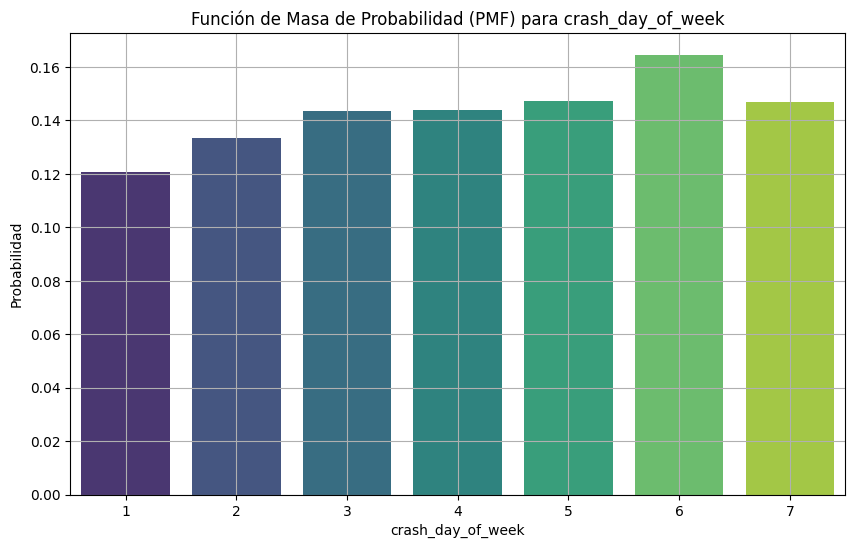

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cálculo de la Función de Masa de Probabilidad (PMF)
def calculate_pmf(data, column):

    value_counts = data[column].value_counts() # Conteo de valores únicos
    total_values = len(data[column])
    
    pmf = value_counts / total_values # PMF = Frecuencia de cada valor / Total de valores
    return pmf

# Visualización de la PMF
def plot_pmf(pmf, column):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=pmf.index, y=pmf.values, palette='viridis')
    plt.title(f'Función de Masa de Probabilidad (PMF) para {column}')
    plt.xlabel(column)
    plt.ylabel('Probabilidad')
    plt.grid(True)
    plt.show()

# PMF para crash_day_of_week (variable discreta) para ver la probabilidad de accidentes por día de la semana
pmf_crash_day = calculate_pmf(data, 'crash_day_of_week')
plot_pmf(pmf_crash_day, 'crash_day_of_week')


La anterior grafica nos muestra que los accidentes de tránsito tienen mayor probabilidad de ocurrir los sábados (día 6), posiblemente debido al aumento de la movilidad social, el ocio nocturno y el consumo de alcohol, mientras que los lunes presentan la menor incidencia (día 1), asociada a la rutina laboral y menor actividad recreativa.

Esta distribución refleja cómo los patrones de comportamiento humano y la dinámica social influyen directamente en la frecuencia de los incidentes, lo que sugiere la necesidad de estrategias preventivas focalizadas, como campañas de sensibilización y refuerzo de la vigilancia en los días críticos, con el fin de reducir los riesgos y mejorar la seguridad vial.

/tmp/ipykernel_3700/3209131960.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pmf.index, y=pmf.values, palette='viridis')


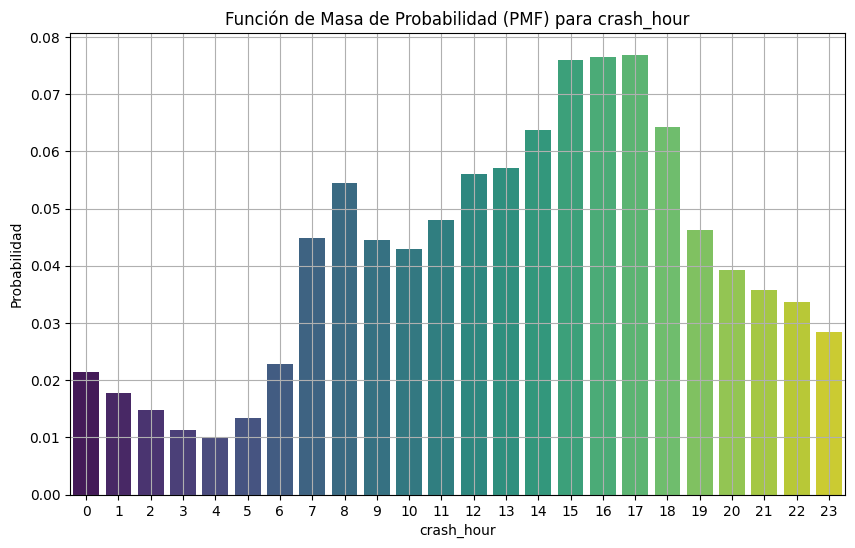

In [29]:
# PMF para crash_hour
pmf_crash_hour = calculate_pmf(data, 'crash_hour')
plot_pmf(pmf_crash_hour, 'crash_hour')

Lo anterior refleja que los accidentes de tránsito tienen una mayor probabilidad de ocurrir entre las 15:00 y las 17:00 horas, lo que coincide con el horario de mayor tráfico debido al cierre de la jornada laboral y escolar. La probabilidad disminuye progresivamente después de las 18:00 horas, reflejando la descongestión del tráfico. Las horas de la madrugada, especialmente entre las 3:00 y las 5:00 horas, presentan la menor incidencia, probablemente por la baja circulación de vehículos.

 Este patrón sugiere que la congestión vehicular y la fatiga pueden ser factores clave en la frecuencia de los accidentes, destacando la necesidad de implementar medidas de regulación y concienciación en los horarios de mayor riesgo para mitigar la siniestralidad vial.

/tmp/ipykernel_3700/3209131960.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pmf.index, y=pmf.values, palette='viridis')


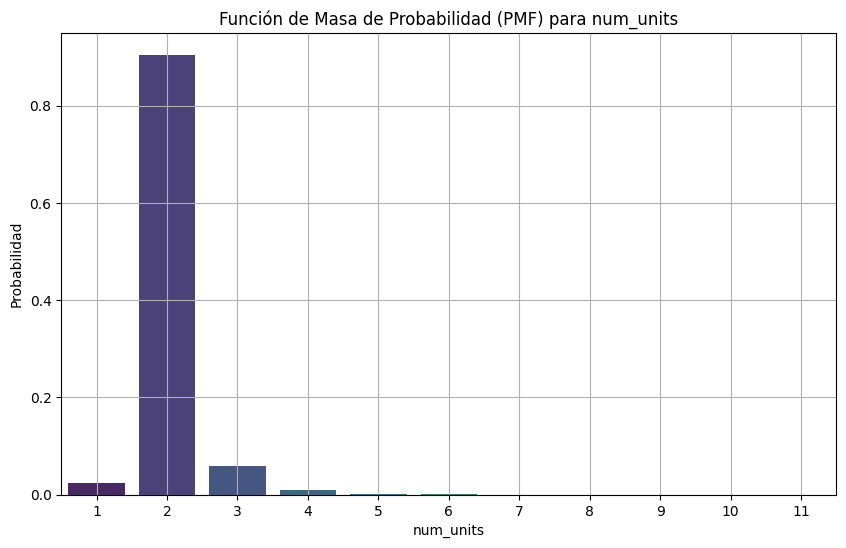

In [30]:
# PMF para num_units
pmf_num_units = calculate_pmf(data, 'num_units')
plot_pmf(pmf_num_units, 'num_units')

Esto que la mayoría de los accidentes de tránsito involucran dos unidades, con una probabilidad significativamente alta en comparación con otros valores, lo que sugiere que los choques entre dos vehículos son los más comunes. Los incidentes con una sola unidad, posiblemente relacionados con colisiones contra objetos fijos o pérdida de control, presentan una probabilidad mucho menor. Los accidentes que involucran tres o más unidades son escasos, lo que indica que los eventos de múltiples vehículos son menos frecuentes. 

Esta distribución destaca la relevancia de las colisiones frontales o laterales entre dos vehículos como causa predominante, lo que sugiere la necesidad de fortalecer las medidas de prevención en cruces viales y vías de alta circulación para minimizar este tipo de incidentes.

/tmp/ipykernel_3700/3209131960.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pmf.index, y=pmf.values, palette='viridis')


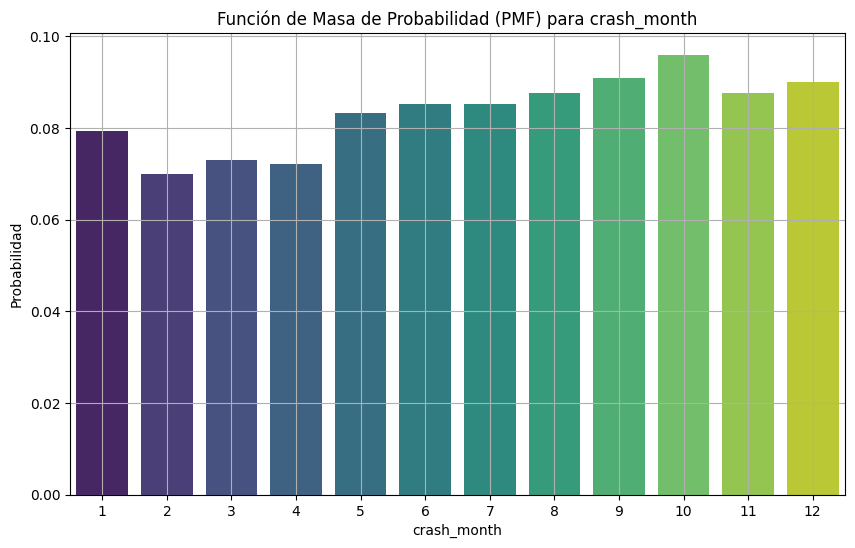

In [31]:
# PMF para crash_month
pmf_crash_month = calculate_pmf(data, 'crash_month')
plot_pmf(pmf_crash_month, 'crash_month')

 Esto evidencia que los incidentes de tránsito se distribuyen de manera relativamente uniforme a lo largo del año, con una ligera tendencia al aumento en los meses finales, especialmente en octubre. Este patrón puede estar relacionado con factores estacionales como el incremento de la movilidad por festividades, mayor afluencia vehicular o condiciones climáticas que afectan la seguridad vial. 
 
 La disminución en los primeros meses podría asociarse a la reducción del tráfico por vacaciones o ajustes económicos de inicio de año. Esta visión integral permite identificar posibles periodos críticos para implementar campañas de prevención y reforzar la vigilancia en los meses con mayor probabilidad de accidentes.

#### Función de densidad de probabilidad

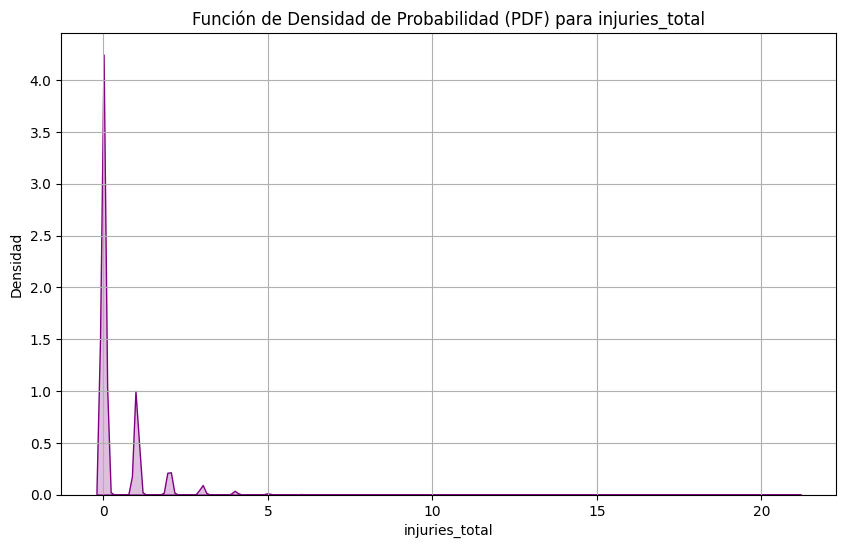

In [32]:
# Función para graficar la PDF
def plot_pdf(data, column):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data[column], fill=True, color="purple")
    plt.title(f"Función de Densidad de Probabilidad (PDF) para {column}")
    plt.xlabel(column)
    plt.ylabel("Densidad")
    plt.grid(True)
    plt.show()

# PDF para injuries_total
plot_pdf(data, 'injuries_total')


Lo anterior indica que la mayoría de los incidentes de tránsito involucran un número bajo de lesiones, con una densidad máxima cercana a cero, lo que indica que la probabilidad de tener pocas lesiones es significativamente mayor que la de tener muchas. La distribución muestra una fuerte asimetría positiva, con valores extremos que se alejan hacia la derecha, lo que sugiere que los eventos con muchas lesiones son poco comunes.

Este patrón puede estar relacionado con la naturaleza de los accidentes, donde la mayoría de los incidentes tienden a ser de menor gravedad debido a factores como las condiciones climáticas, el tipo de vía o el cumplimiento de las normas de tránsito.

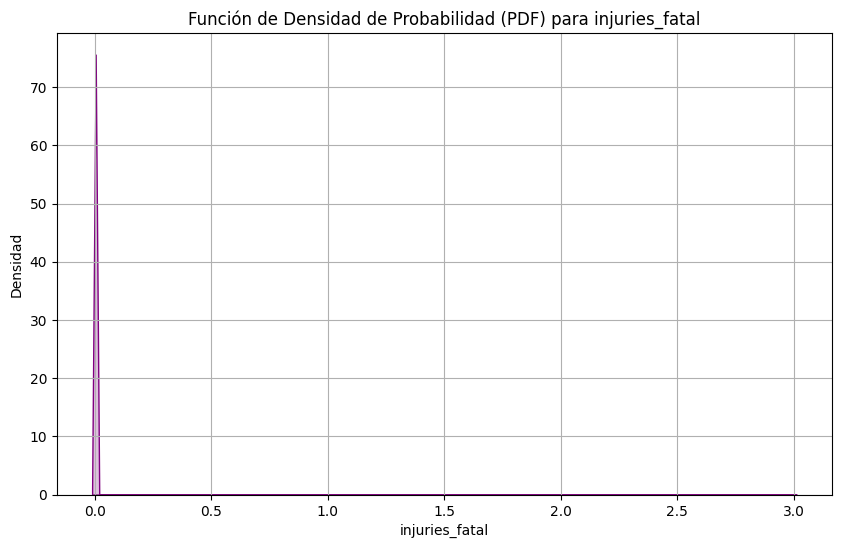

In [33]:
# PDF para injuries_fatal
plot_pdf(data, 'injuries_fatal')

Esto muestra una alta concentración en el valor cero, lo que sugiere que la gran mayoría de los incidentes de tránsito no resultan en víctimas fatales. La densidad disminuye a medida que aumenta el número de fatalidades, evidenciando que los accidentes con muertes son eventos altamente improbables. 

Esta distribución refleja que los factores asociados con la gravedad de los accidentes, como la velocidad, el tipo de vía, o las condiciones climáticas, influyen en la baja frecuencia de fatalidades. La presencia de unos pocos valores distintos de cero destaca la necesidad de medidas preventivas para reducir la ocurrencia de estos eventos excepcionales.

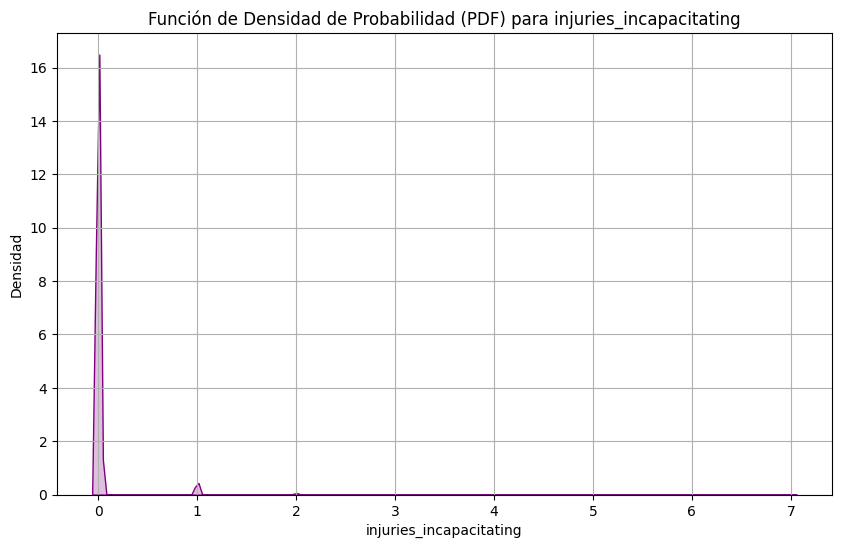

In [34]:
# PDF para injuries_incapacitating
plot_pdf(data, 'injuries_incapacitating')

De manera similar, esto también revela que la mayoría de los incidentes de tránsito no generan lesiones incapacitantes, con una alta concentración en el valor cero. La densidad disminuye rápidamente a medida que aumentan las lesiones, indicando que los accidentes con consecuencias graves son poco frecuentes. 

Esta distribución sugiere que, si bien la mayoría de los accidentes tienen consecuencias leves, los eventos con lesiones incapacitantes podrían estar relacionados con factores como la velocidad del vehículo, el uso de dispositivos de seguridad o las condiciones del entorno. 

#### Función de distribución acumulativa

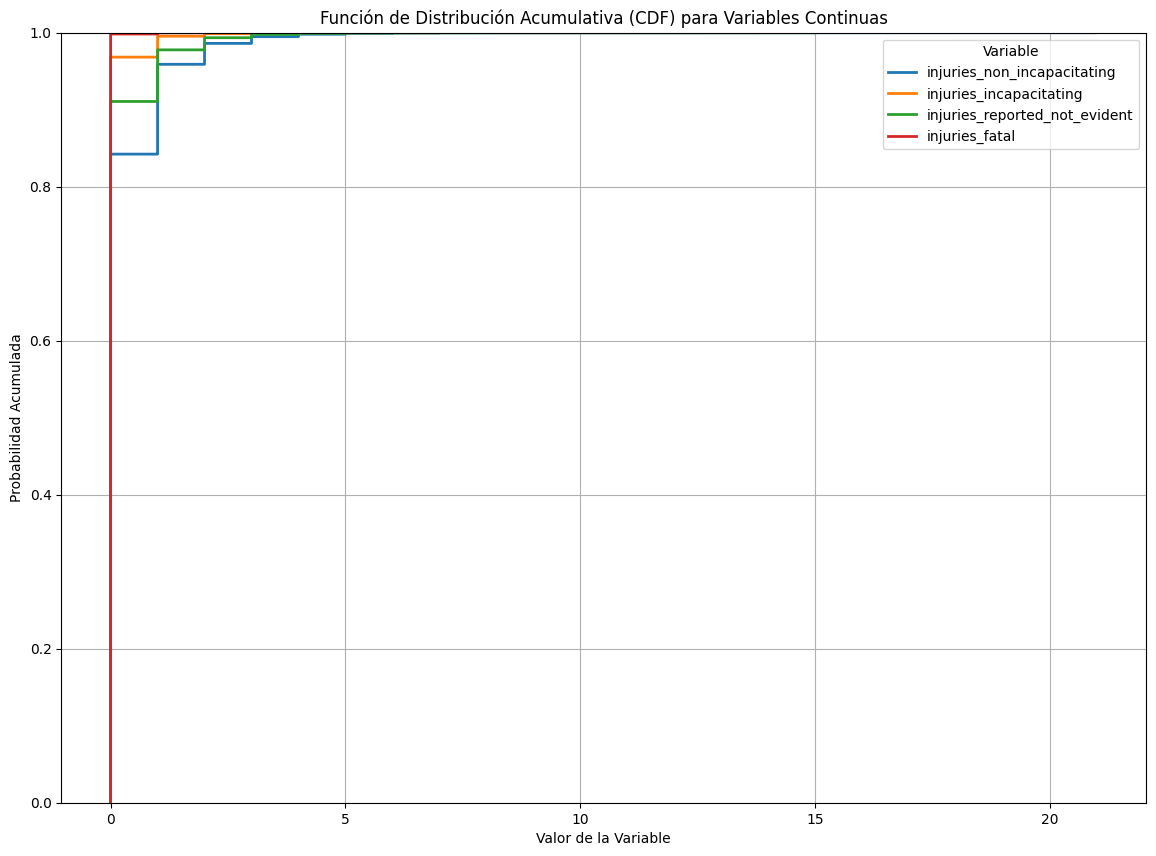

In [35]:
import numpy as np

# CDF con variables continuas
continuous_vars = [ 'injuries_non_incapacitating', 'injuries_incapacitating','injuries_reported_not_evident', 'injuries_fatal' ]

plt.figure(figsize=(14, 10))

# Iterar sobre cada variable y graficar la CDF
for var in continuous_vars:
    sns.ecdfplot(data[var], label=var, linewidth=2)

plt.title('Función de Distribución Acumulativa (CDF) para Variables Continuas')
plt.xlabel('Valor de la Variable')
plt.ylabel('Probabilidad Acumulada')
plt.legend(title='Variable')
plt.grid(True)
plt.show()


Lo anterior refleja la frecuencia y gravedad de las consecuencias de los accidentes de tráfico, porque observa que la mayoría de los accidentes no presentan lesiones fatales, lo cual se refleja en la curva roja que alcanza rápidamente el valor máximo con probabilidades acumuladas cercanas a 1 en valores muy bajos. Las lesiones no incapacitantes y las lesiones reportadas pero no evidentes son las más comunes, con una acumulación más gradual, indicando que la mayoría de los accidentes generan pocas lesiones visibles o leves. Las lesiones incapacitantes presentan una acumulación intermedia, lo que sugiere que los accidentes con daños graves son menos frecuentes.

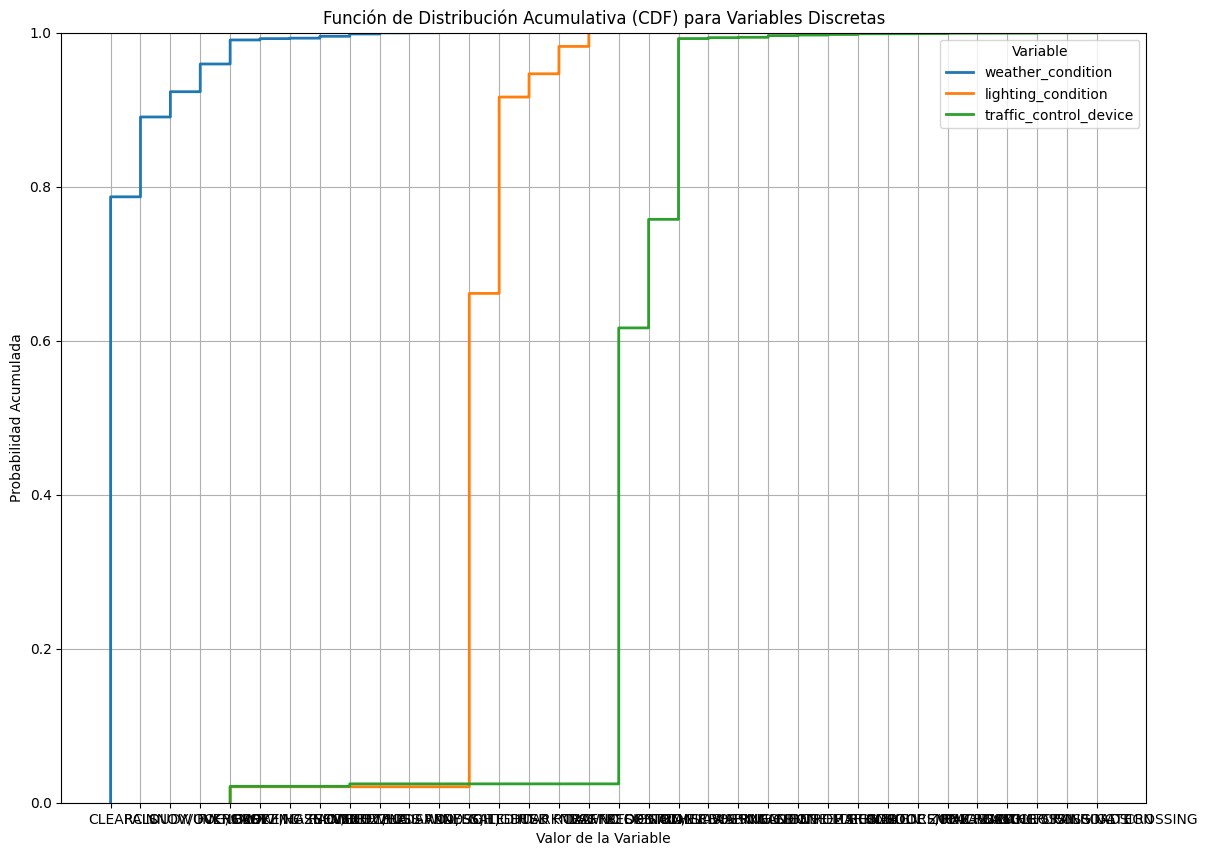

In [36]:
# CDF para variable discreta
discrete_vars = ['weather_condition', 'lighting_condition', 'traffic_control_device']

plt.figure(figsize=(14, 10))

# Iterar sobre cada variable discreta y graficar la CDF
for var in discrete_vars:
    sns.ecdfplot(data[var], label=var, linewidth=2)

plt.title('Función de Distribución Acumulativa (CDF) para Variables Discretas')
plt.xlabel('Valor de la Variable')
plt.ylabel('Probabilidad Acumulada')
plt.legend(title='Variable')
plt.grid(True)
plt.show()

En la gráfica se puede ver cómo se distribuyen estas características en los accidentes de tránsito. Se observa que la mayoría de los accidentes ocurren bajo condiciones climáticas favorables, con una probabilidad acumulada que aumenta rápidamente para valores bajos, lo que indica que el mal clima es poco frecuente. Las condiciones de iluminación también muestran que la mayoría de los incidentes suceden con buena visibilidad, mientras que los dispositivos de control de tráfico tienden a estar presentes en la mayoría de los accidentes.

#### Medidas de tendencia central


--- Medidas de Tendencia Central ---
Mediana:
num_units                         2.0
injuries_total                    0.0
injuries_fatal                    0.0
injuries_incapacitating           0.0
injuries_non_incapacitating       0.0
injuries_reported_not_evident     0.0
injuries_no_indication            2.0
crash_hour                       14.0
crash_day_of_week                 4.0
crash_month                       7.0
dtype: float64


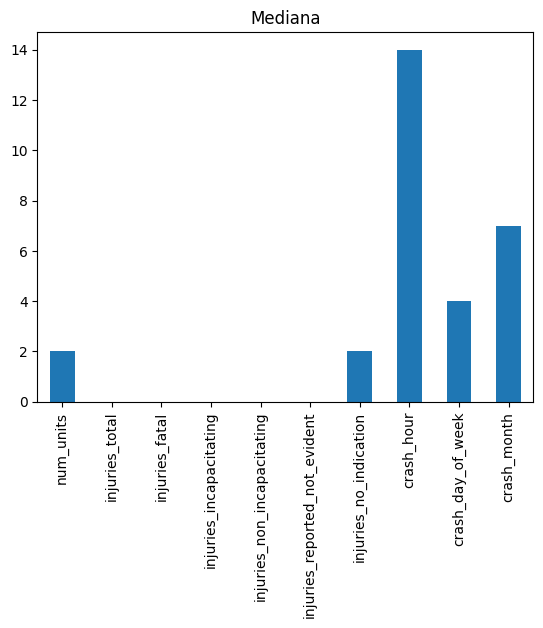

In [37]:
from scipy.stats import skew, kurtosis

# Mediana
print("\n--- Medidas de Tendencia Central ---")
print("Mediana:")
median = data.median(numeric_only=True)
print(median)
median.plot(kind='bar', title='Mediana')
plt.show()


La mediana revela que la mayoría de los accidentes involucran dos vehículos, sin generar lesiones graves, ya que la mayoría de las víctimas no presentan heridas o no se reportan. Los accidentes suelen ocurrir alrededor de las 2 PM, especialmente los ultimos dias de la semana, con mayor incidencia en el mes de julio, posiblemente debido a la alta movilidad durante días laborales y temporadas vacacionales.

In [38]:
print("\nModa:")
mode = data.mode().iloc[0]
print(mode)
mode.plot(kind='bar', title='Moda')
plt.show()


Moda:
crash_date                        12/29/2020 05:00:00 PM
traffic_control_device                    TRAFFIC SIGNAL
weather_condition                                  CLEAR
lighting_condition                              DAYLIGHT
first_crash_type                                 TURNING
trafficway_type                              NOT DIVIDED
alignment                             STRAIGHT AND LEVEL
roadway_surface_cond                                 DRY
road_defect                                   NO DEFECTS
crash_type                        NO INJURY / DRIVE AWAY
intersection_related_i                                 Y
damage                                       OVER $1,500
prim_contributory_cause              UNABLE TO DETERMINE
num_units                                              2
most_severe_injury               NO INDICATION OF INJURY
injuries_total                                       0.0
injuries_fatal                                       0.0
injuries_incapacitating 

TypeError: no numeric data to plot

### Step 5: Perform a full EDA

In [39]:
# Obtain dimensions
data.shape

(209306, 24)

El dataset contiene un total de 209306 registros cuyos atributos se distribuyen en 24 columnas

In [40]:
# Obtain information about data types and non-null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209306 entries, 0 to 209305
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   crash_date                     209306 non-null  object 
 1   traffic_control_device         209306 non-null  object 
 2   weather_condition              209306 non-null  object 
 3   lighting_condition             209306 non-null  object 
 4   first_crash_type               209306 non-null  object 
 5   trafficway_type                209306 non-null  object 
 6   alignment                      209306 non-null  object 
 7   roadway_surface_cond           209306 non-null  object 
 8   road_defect                    209306 non-null  object 
 9   crash_type                     209306 non-null  object 
 10  intersection_related_i         209306 non-null  object 
 11  damage                         209306 non-null  object 
 12  prim_contributory_cause       

- Hay un total de 209306 registros
- 10 variables son de tipo numérico, y 14 son categóricas.
- No se detectó ningún registro con columnas nulas.


In [41]:
if data.duplicated().sum():
    print("Duplicados encontrados: ",data.duplicated().sum())
    total_data = data.drop_duplicates()
print(total_data.shape)
total_data.head()

Duplicados encontrados:  31
(209275, 24)


,crash_date,traffic_control_device,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,crash_type,...,most_severe_injury,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,crash_hour,crash_day_of_week,crash_month
0,07/29/2023 01:00:00 PM,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,13,7,7
1,08/13/2023 12:11:00 AM,TRAFFIC SIGNAL,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0,1,8
2,12/09/2021 10:30:00 AM,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,REAR END,T-INTERSECTION,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,10,5,12
3,08/09/2023 07:55:00 PM,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,ANGLE,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,INJURY AND / OR TOW DUE TO CRASH,...,NONINCAPACITATING INJURY,5.0,0.0,0.0,5.0,0.0,0.0,19,4,8
4,08/19/2023 02:55:00 PM,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,REAR END,T-INTERSECTION,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,14,7,8


In [42]:
data.drop(["crash_date", "first_crash_type", "damage", "injuries_total"], axis = 1, inplace = True)
data.head()

,traffic_control_device,weather_condition,lighting_condition,trafficway_type,alignment,roadway_surface_cond,road_defect,crash_type,intersection_related_i,prim_contributory_cause,num_units,most_severe_injury,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,crash_hour,crash_day_of_week,crash_month
0,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,NOT DIVIDED,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,NO INJURY / DRIVE AWAY,Y,UNABLE TO DETERMINE,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,3.0,13,7,7
1,TRAFFIC SIGNAL,CLEAR,"DARKNESS, LIGHTED ROAD",FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,Y,IMPROPER TURNING/NO SIGNAL,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,2.0,0,1,8
2,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,T-INTERSECTION,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,Y,FOLLOWING TOO CLOSELY,3,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,3.0,10,5,12
3,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,INJURY AND / OR TOW DUE TO CRASH,Y,UNABLE TO DETERMINE,2,NONINCAPACITATING INJURY,0.0,0.0,5.0,0.0,0.0,19,4,8
4,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,T-INTERSECTION,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,NO INJURY / DRIVE AWAY,Y,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,3.0,14,7,8


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209306 entries, 0 to 209305
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   traffic_control_device         209306 non-null  object 
 1   weather_condition              209306 non-null  object 
 2   lighting_condition             209306 non-null  object 
 3   trafficway_type                209306 non-null  object 
 4   alignment                      209306 non-null  object 
 5   roadway_surface_cond           209306 non-null  object 
 6   road_defect                    209306 non-null  object 
 7   crash_type                     209306 non-null  object 
 8   intersection_related_i         209306 non-null  object 
 9   prim_contributory_cause        209306 non-null  object 
 10  num_units                      209306 non-null  int64  
 11  most_severe_injury             209306 non-null  object 
 12  injuries_fatal                

- Hay un total de 209306 cuyos atributos se encuentran distribuidos en 20 columnas.
- 9 variables se consideran numéricas debido a que sus atributos sirven para contabilizar.
- 11 variables son categóricas.

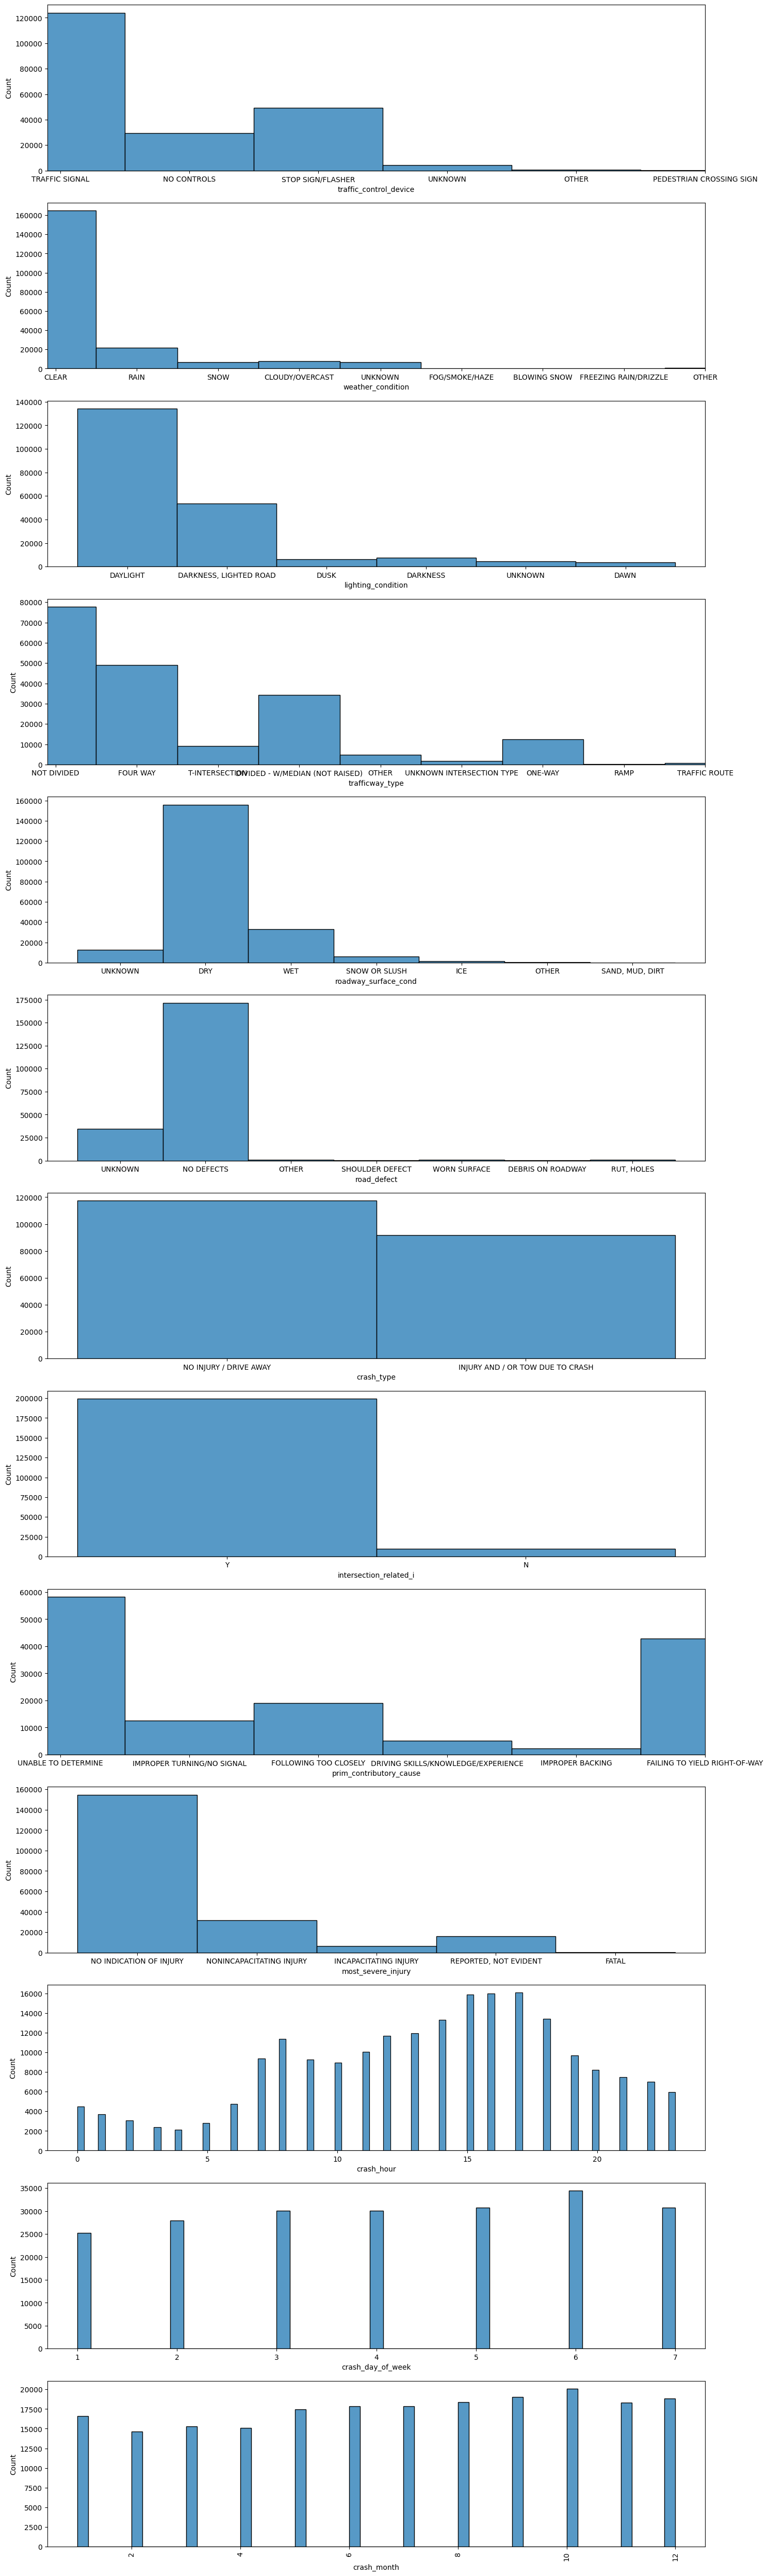

In [44]:
import matplotlib.pyplot as plt 
import seaborn as sns

fig, axis = plt.subplots(13, figsize = (15, 50))

# Create a multiple histogram
sns.histplot(ax = axis[0], data = data, x = "traffic_control_device").set_xlim(-0.1, 5)
sns.histplot(ax = axis[1], data = data, x = "weather_condition").set_xlim(-0.1, 8)
sns.histplot(ax = axis[2], data = data, x = "lighting_condition")
sns.histplot(ax = axis[3], data = data, x = "trafficway_type").set_xlim(-0.1, 8)
sns.histplot(ax = axis[4], data = data, x = "roadway_surface_cond")
sns.histplot(ax = axis[5], data = data, x = "road_defect")
sns.histplot(ax = axis[6], data = data, x = "crash_type")
sns.histplot(ax = axis[7], data = data, x = "intersection_related_i")
sns.histplot(ax = axis[8], data = data, x = "prim_contributory_cause").set_xlim(-0.1, 5)
sns.histplot(ax = axis[9], data = data, x = "most_severe_injury")
sns.histplot(ax = axis[10], data = data, x = "crash_hour")
sns.histplot(ax = axis[11], data = data, x = "crash_day_of_week")
sns.histplot(ax = axis[12], data = data, x = "crash_month")


# Adjust the layout
plt.tight_layout()
plt.xticks(rotation=90)

# Show the plot
plt.show()

- Cuando las condiciones climáticas y de carretera son optimas, el riesgo de accidente vial aumenta debido al factor humano de forma significativa.
- Existen más accidentes de tráfico en vialidades donde hay semáforos
- La mayoría de los accidentes es causado por factores humanos, tal como se concluyó anteriormente
- No hubieron heridos reportados en la mayor parte de los accidentes registrados.
- De 3 a 5 pm existe una mayor probabilidad de que ocurra un accidente
- Los viernes son más propensos a accidentes
- Octubre es el mes con el mayor número de accidentes registrados

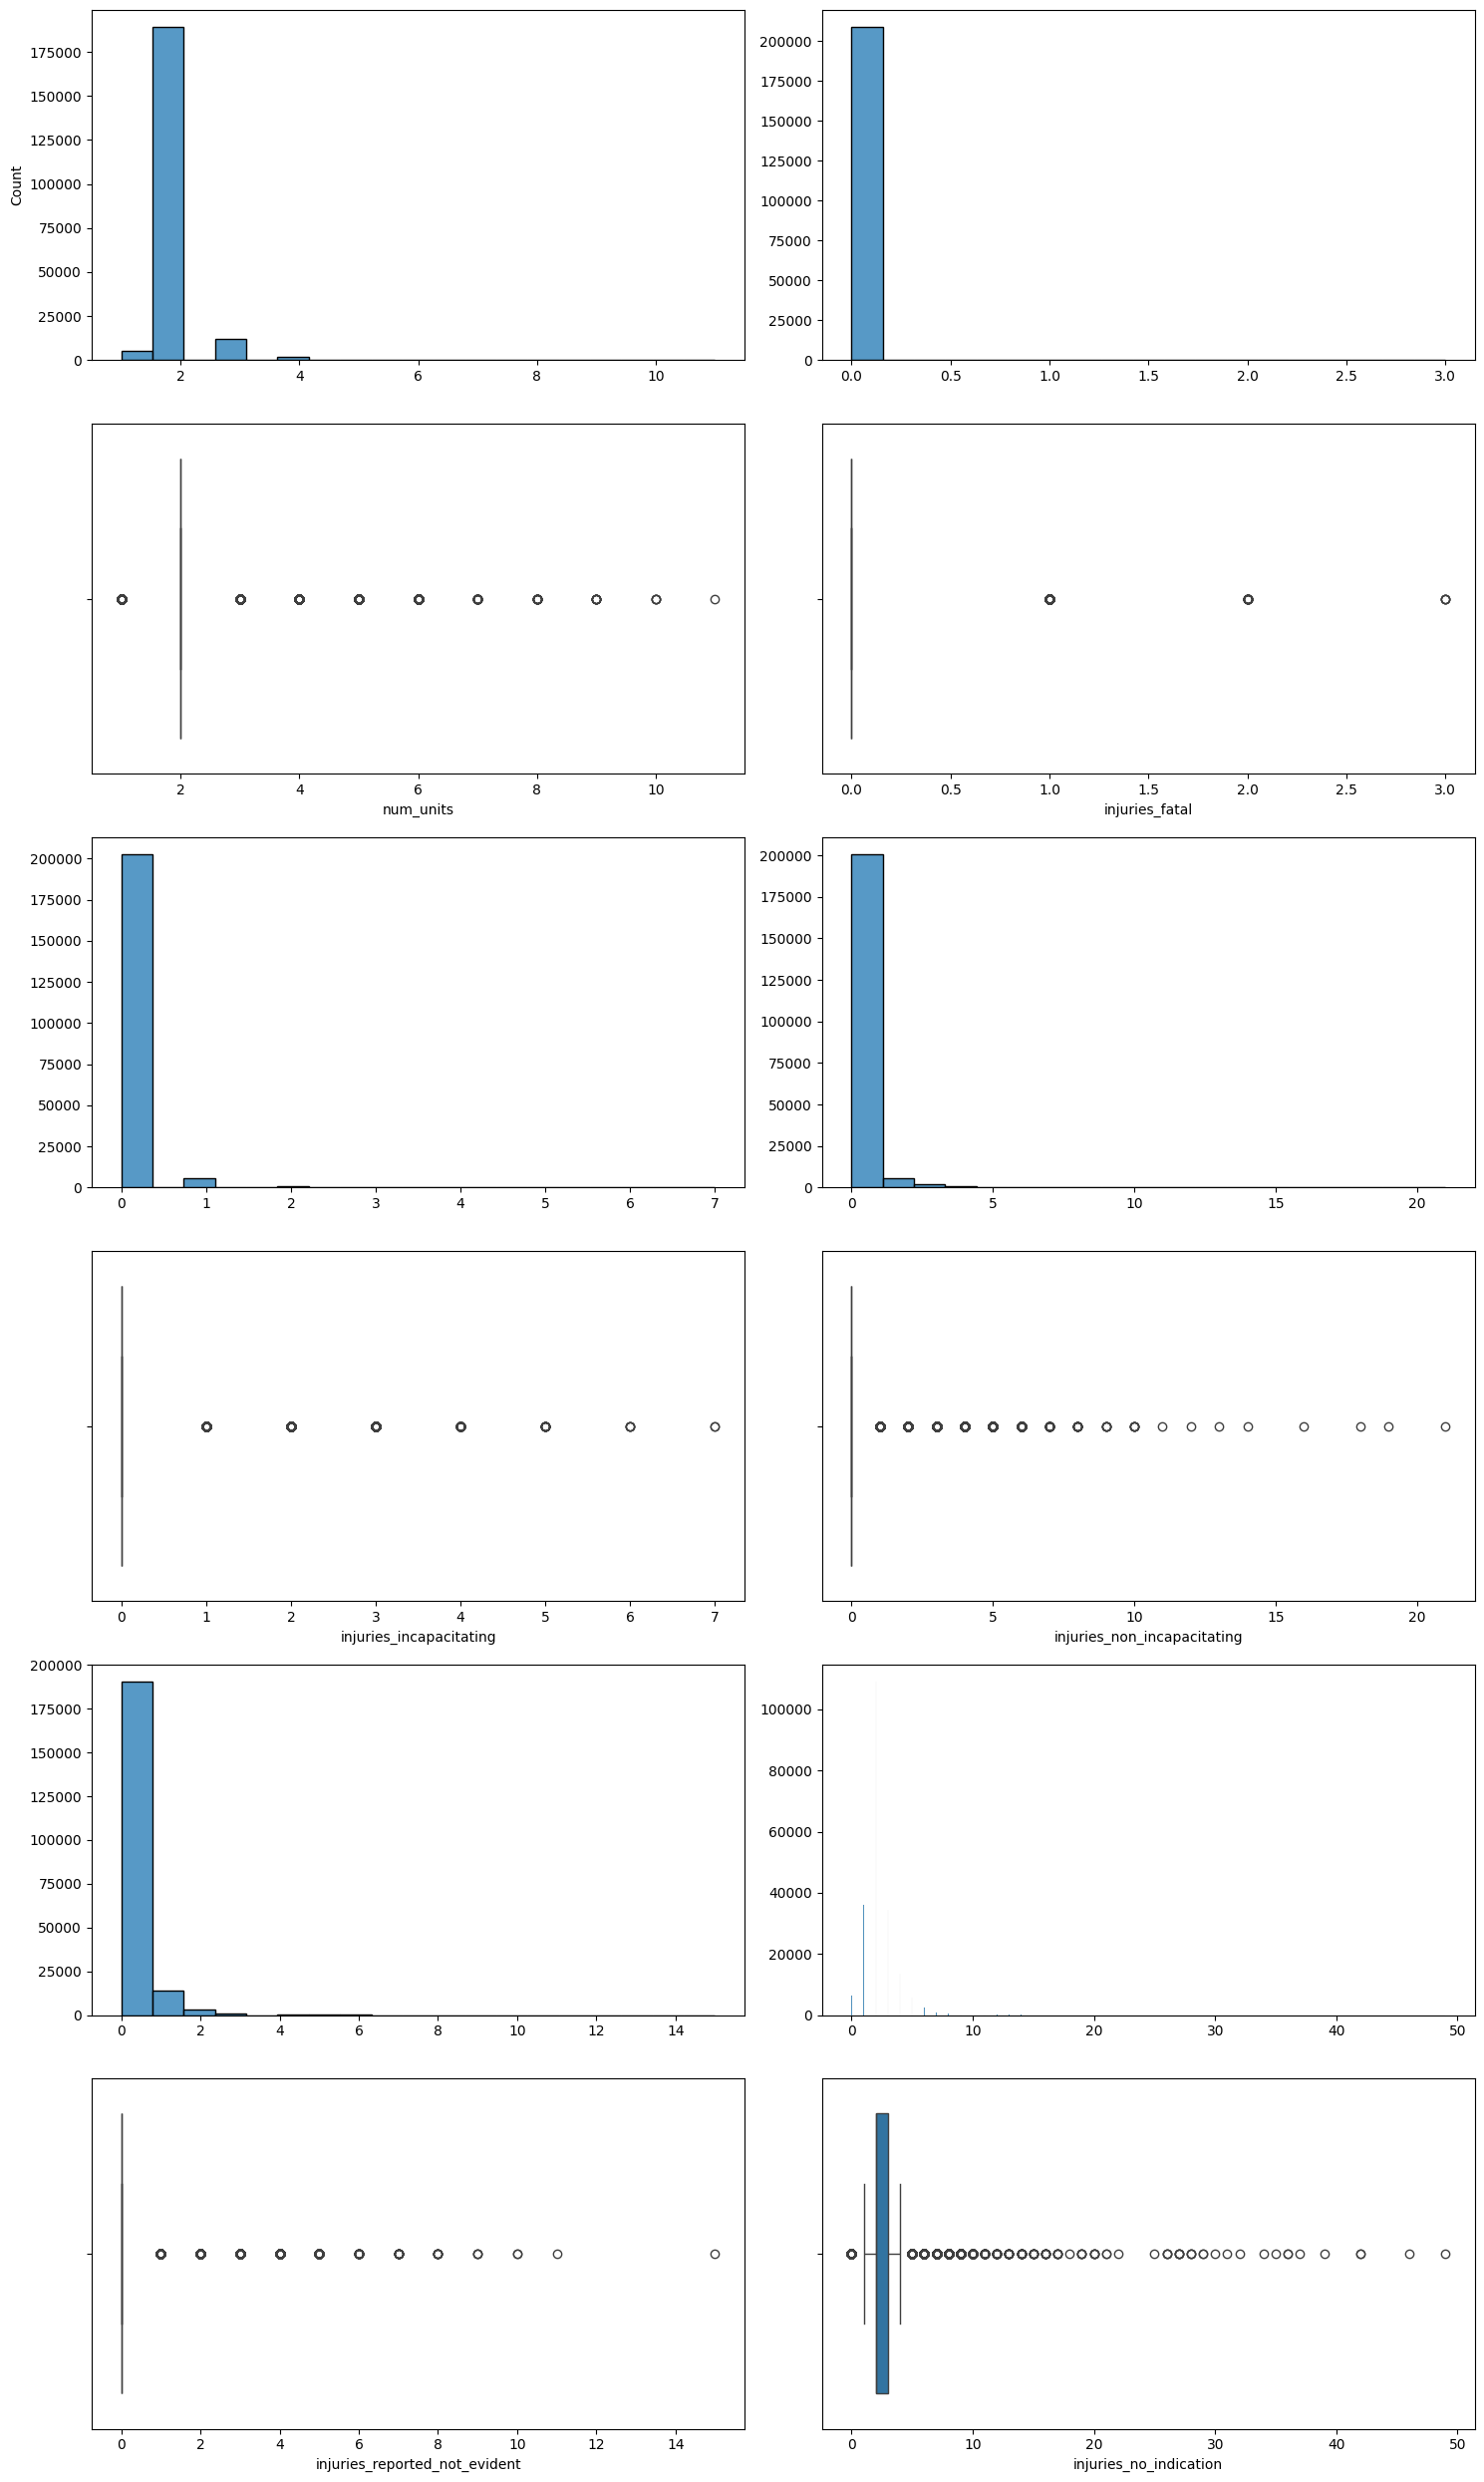

In [45]:
fig, axis = plt.subplots(6, 2, figsize = (15, 25))

# Creating a multiple figure with histograms and box plots
sns.histplot(ax = axis[0, 0], data = data, x = "num_units").set(xlabel = None)
sns.boxplot(ax = axis[1, 0], data = data, x = "num_units")
sns.histplot(ax = axis[0, 1], data = data, x = "injuries_fatal").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[1, 1], data = data, x = "injuries_fatal")
sns.histplot(ax = axis[2, 0], data = data, x = "injuries_incapacitating").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[3, 0], data = data, x = "injuries_incapacitating")
sns.histplot(ax = axis[2, 1], data = data, x = "injuries_non_incapacitating").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[3, 1], data = data, x = "injuries_non_incapacitating")
sns.histplot(ax = axis[4, 0], data = data, x = "injuries_reported_not_evident").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[5, 0], data = data, x = "injuries_reported_not_evident")
sns.histplot(ax = axis[4, 1], data = data, x = "injuries_no_indication").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[5, 1], data = data, x = "injuries_no_indication")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

Agregar explicación del porqué se consideran numéricas

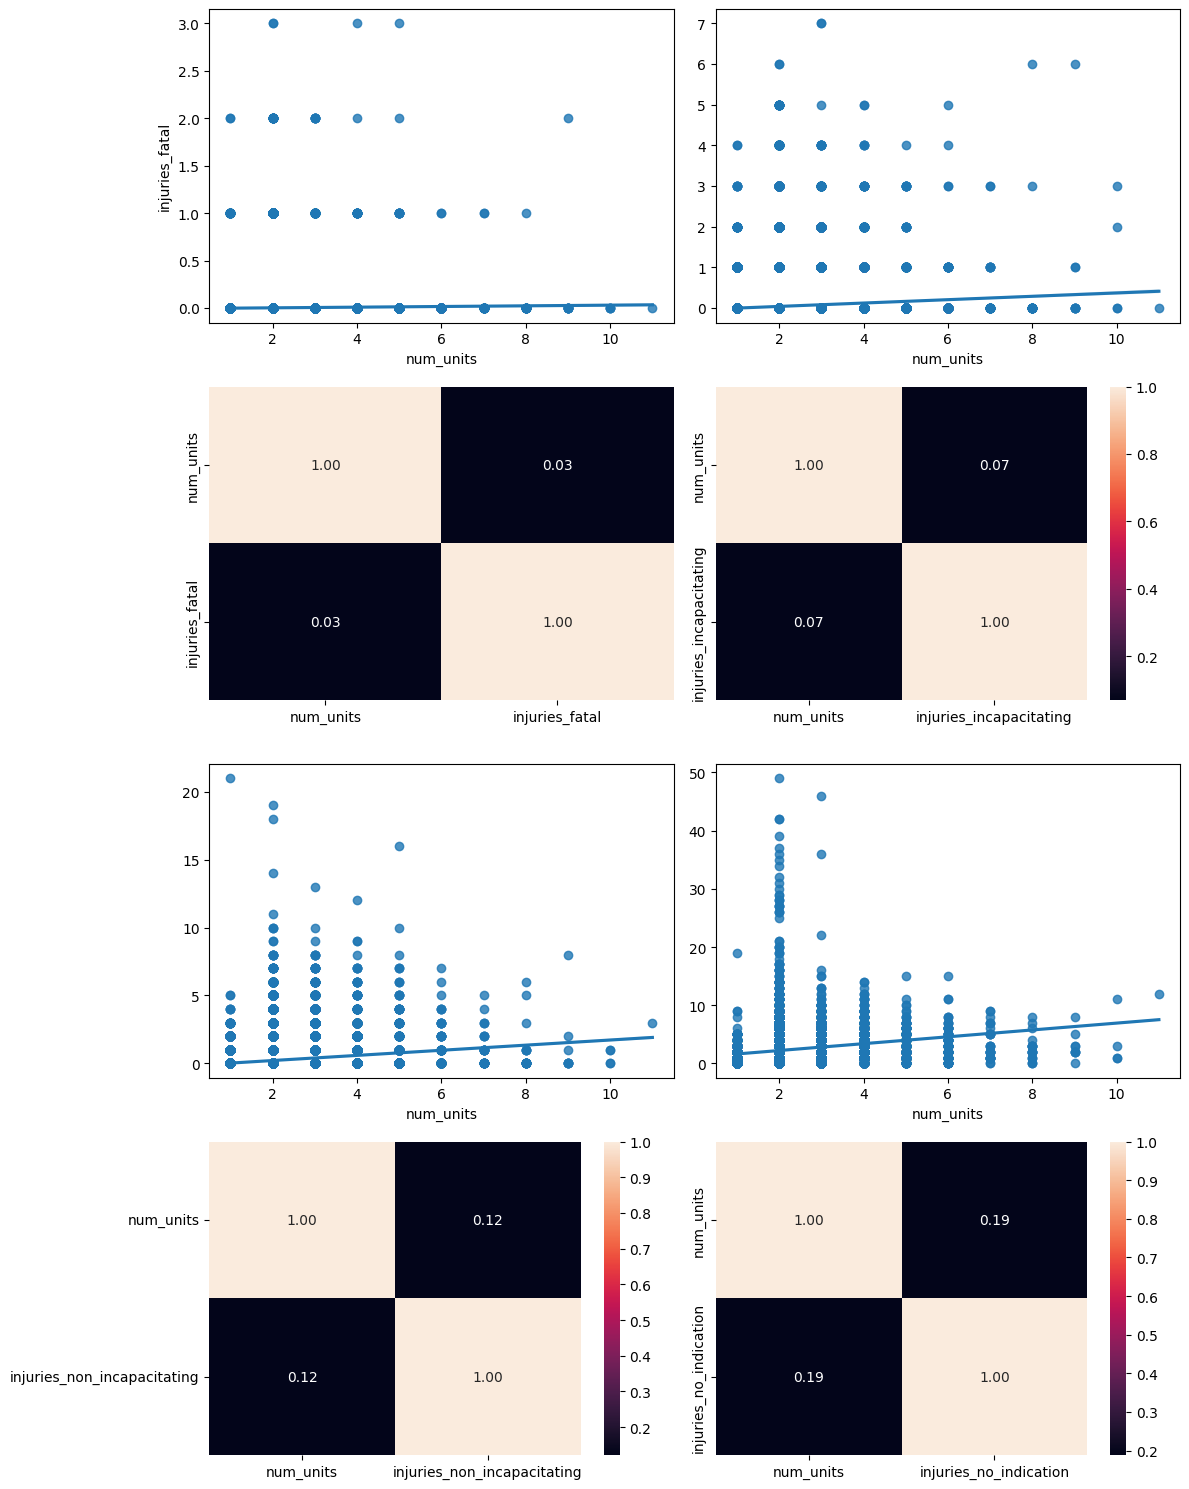

In [46]:
fig, axis = plt.subplots(4, 2, figsize = (12, 15))

# Create a multiple scatter diagram
sns.regplot(ax = axis[0, 0], data = data, x = "num_units", y = "injuries_fatal")
sns.heatmap(data[["num_units", "injuries_fatal"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0], cbar = False)
sns.regplot(ax = axis[0, 1], data = data, x = "num_units", y = "injuries_incapacitating").set(ylabel=None)
sns.heatmap(data[["num_units", "injuries_incapacitating"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1])
sns.regplot(ax = axis[2, 0], data = data, x = "num_units", y = "injuries_non_incapacitating").set(ylabel=None)
sns.heatmap(data[["num_units", "injuries_non_incapacitating"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 0])
sns.regplot(ax = axis[2, 1], data = data, x = "num_units", y = "injuries_no_indication").set(ylabel=None)
sns.heatmap(data[["num_units", "injuries_no_indication"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 1])

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

Según los gráficos generados, no existe ninguna relación de peso entre las variables num_units e injuries (fatal, incapacitatin, non_incapacitating, no_indication). El valor más alto se obtiene con num_units y injuries_no_indication, pero se considera insuficiente para establecer una relación de valor.

/tmp/ipykernel_3700/2829552176.py:10: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


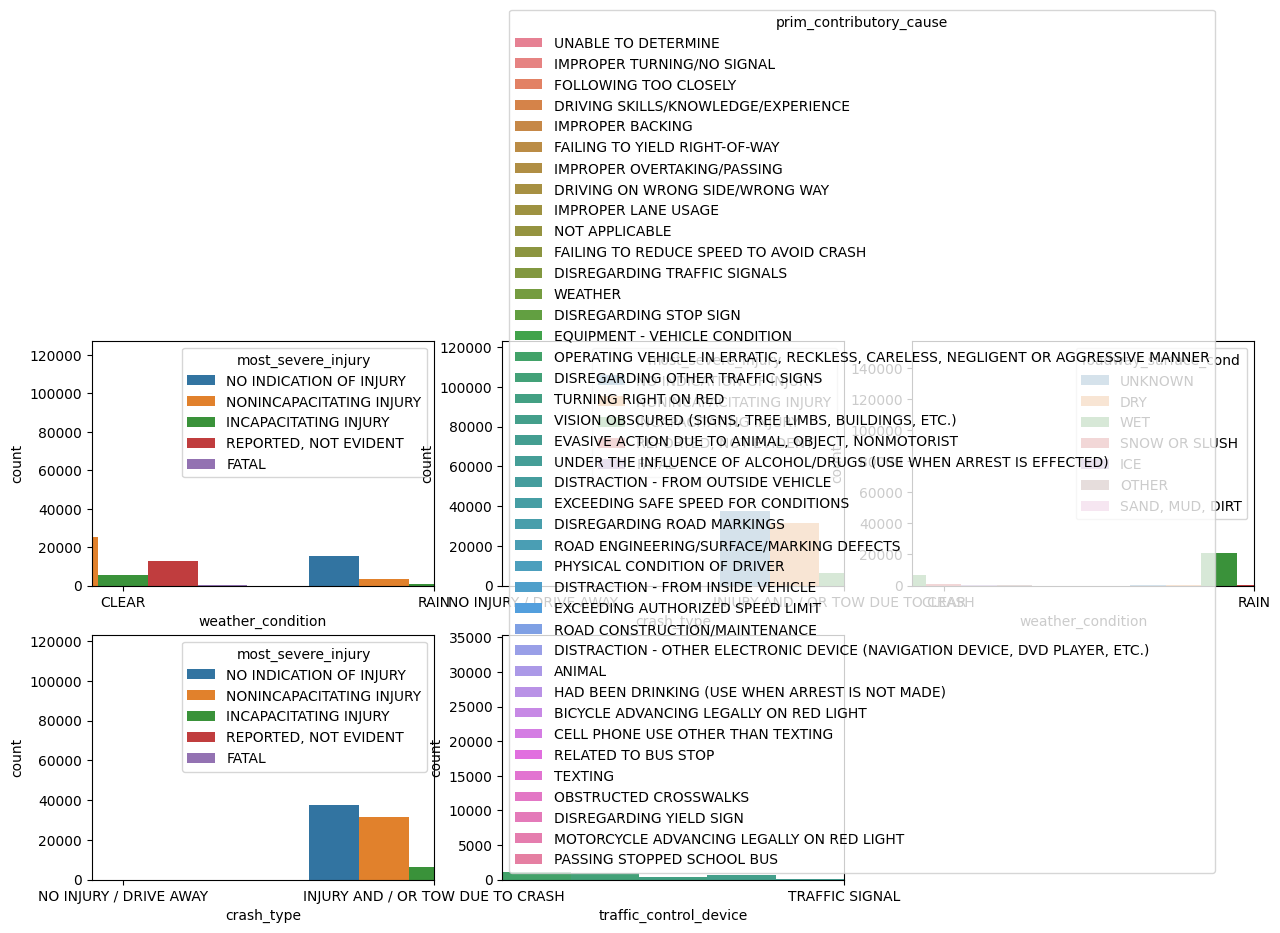

In [47]:
fig, axis = plt.subplots(2, 3, figsize = (15, 7))


sns.countplot(ax = axis[0, 0], data = data, x = "weather_condition", hue = "most_severe_injury", order=data['weather_condition'].value_counts().index).set_xlim(-0.1,1)
sns.countplot(ax = axis[0, 1], data = data, x = "crash_type", hue = "most_severe_injury").set_xlim(-0.1, 1)
sns.countplot(ax = axis[0, 2], data = data, x = "weather_condition", hue = "roadway_surface_cond").set_xlim(-0.1, 1)
sns.countplot(ax = axis[1, 0], data = data, x = "crash_type", hue = "most_severe_injury").set_xlim(-0.1, 1)
sns.countplot(ax = axis[1, 1], data = data, x = "traffic_control_device", hue = "prim_contributory_cause").set_xlim(-0.1, 0)

plt.tight_layout()

fig.delaxes(axis[1, 2])

plt.show()


/tmp/ipykernel_3700/2923313382.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


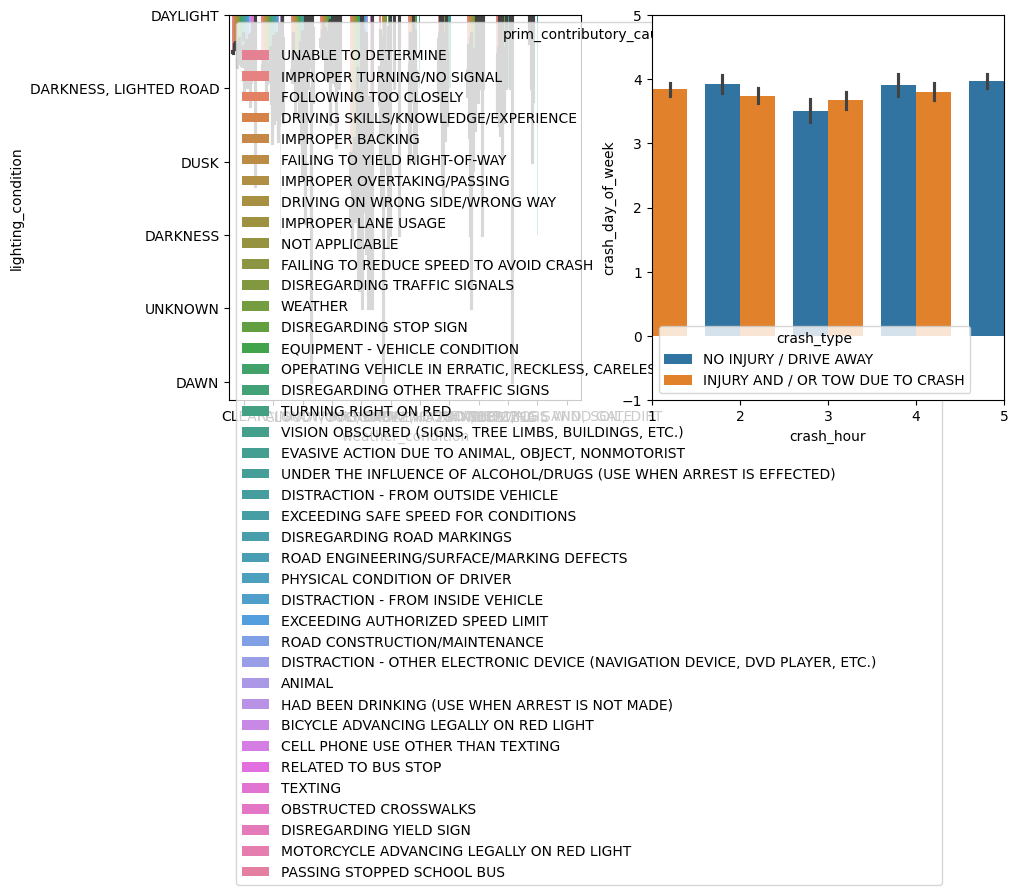

In [48]:
fig, axis = plt.subplots(figsize = (10, 5), ncols = 2)

sns.barplot(ax = axis[0], data = data, x = "weather_condition", y = "lighting_condition",hue = "prim_contributory_cause")
plt.xlim(1,5)
plt.ylim(-1,5)
sns.barplot(ax = axis[1], data = data, x = "crash_hour", y = "crash_day_of_week", hue = "crash_type")

plt.tight_layout()
plt.xlim(1,5)
plt.ylim(-1,5)
plt.show()

In [49]:
#Factorización de las variables categoricas
import pandas as pd

cols = data.select_dtypes(include=object)
cols = cols.columns

for x in cols:
    data[x] = pd.factorize(data[x])[0]



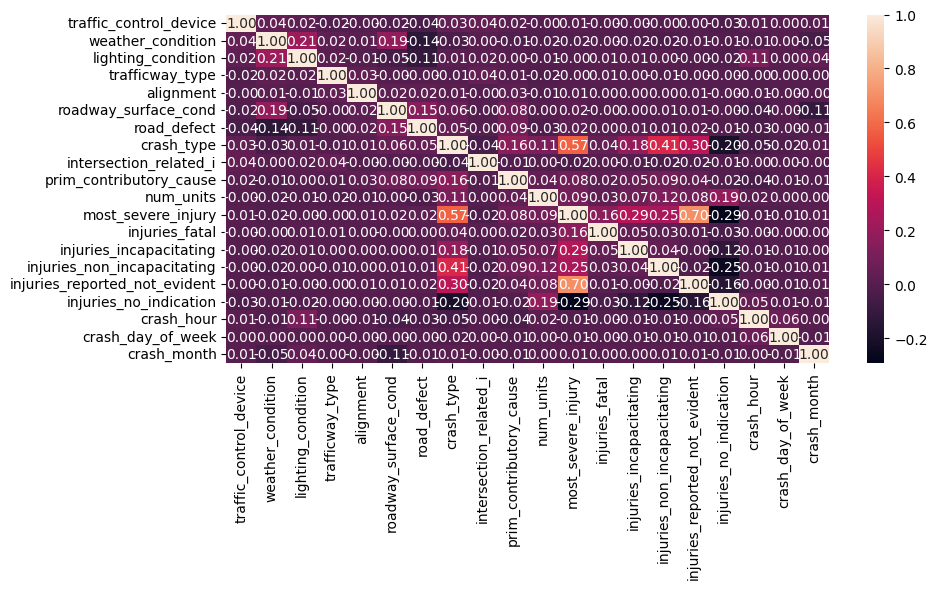

In [50]:
fig, axis = plt.subplots(figsize = (10, 6))

cols = data.columns
sns.heatmap(data[cols].corr(), annot = True, fmt = ".2f")

plt.tight_layout()

plt.show()

El heatmap nos arroja la siguiente información:
- La relación más fuerte existe entre injuries_reported_not_evident y most_severe_injury, con un 0.7, lo que indica que en la mayoría de los accidentes, las heridas no eran visibles y por lo tanto, no fueron reportadas o no eran incapacitantes
- La segunda relación más fuerte esta entre most_severe_injury y crash_type, lo que indica que dependiendo del tipo de choque será la herida más severa. 
- La tercera relacion más fuerte se encuentra entre crash_type e injuries_non_incapacitating, lo que indica de dependiendo del tipo de choque, las heridas pueden ser incapacitantes o no.

En cuanto a relaciones negativas, tenemos que:
- Most_severe_injury e injuries_no_indication, lo que tiene sentido, pues si la herida no es reportada, no se puede saber cuál es la más severa.
- injuries_non_incapacitating e injuries_no_indication, si la herida no es evidente, lo más probable es que no sea reportada.

In [51]:
data.describe()

,traffic_control_device,weather_condition,lighting_condition,trafficway_type,alignment,roadway_surface_cond,road_defect,crash_type,intersection_related_i,prim_contributory_cause,num_units,most_severe_injury,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,crash_hour,crash_day_of_week,crash_month
count,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000
mean,0.752587,0.470273,0.593848,2.375159,0.056984,1.184734,0.877992,0.439213,0.047691,5.255177,2.063300,0.450460,0.001859,0.038102,0.221241,0.121516,2.244002,13.373047,4.144024,6.771822
std,1.181821,1.161146,1.057929,3.400193,0.399250,0.629043,0.550384,0.496292,0.213112,5.716941,0.396012,0.889496,0.047502,0.233964,0.614960,0.450865,1.241175,5.603830,1.966864,3.427593
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,9.000000,2.000000,4.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,14.000000,4.000000,7.000000
75%,2.000000,0.000000,1.000000,3.000000,0.000000,1.000000,1.000000,1.000000,0.000000,9.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,17.000000,6.000000,10.000000
max,18.000000,11.000000,5.000000,19.000000,5.000000,6.000000,6.000000,1.000000,1.000000,39.000000,11.000000,4.000000,3.000000,7.000000,21.000000,15.000000,49.000000,23.000000,7.000000,12.000000


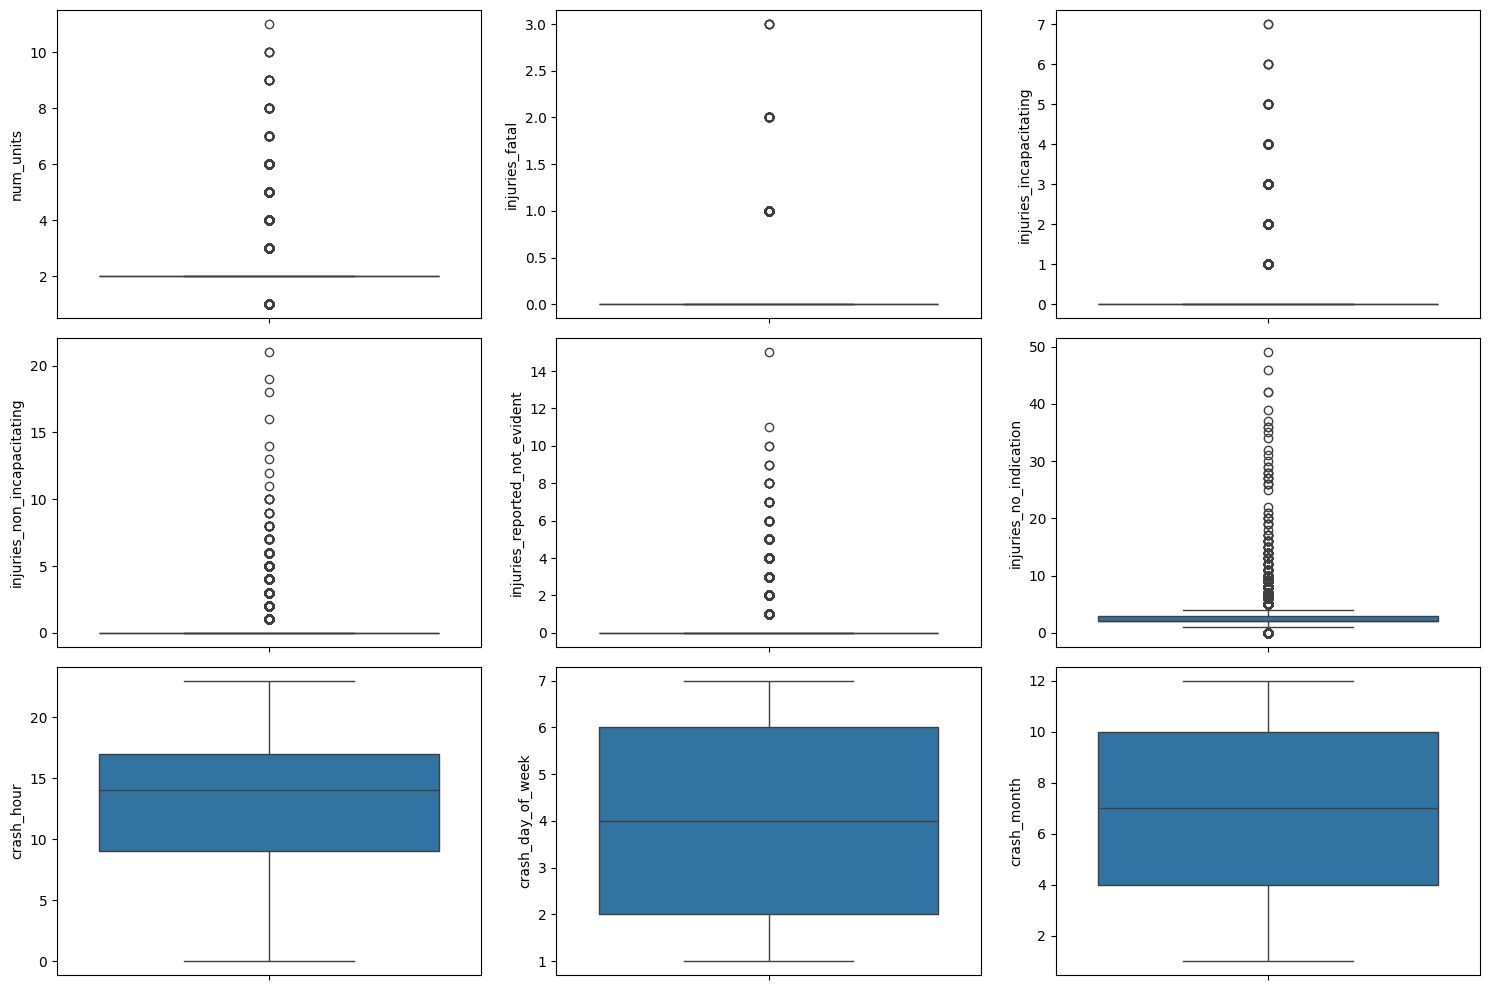

In [52]:
fig, axis = plt.subplots(3, 3, figsize = (15, 10))

sns.boxplot(ax = axis[0, 0], data = data, y = "num_units")
sns.boxplot(ax = axis[0, 1], data = total_data, y = "injuries_fatal")
sns.boxplot(ax = axis[0, 2], data = total_data, y = "injuries_incapacitating")
sns.boxplot(ax = axis[1, 0], data = total_data, y = "injuries_non_incapacitating")
sns.boxplot(ax = axis[1, 1], data = total_data, y = "injuries_reported_not_evident")
sns.boxplot(ax = axis[1, 2], data = total_data, y = "injuries_no_indication")
sns.boxplot(ax = axis[2, 0], data = total_data, y = "crash_hour")
sns.boxplot(ax = axis[2, 1], data = total_data, y = "crash_day_of_week")
sns.boxplot(ax = axis[2, 2], data = total_data, y = "crash_month")

plt.tight_layout()

plt.show()

Los gráficos obtenidos nos indican lo siguiente:
- La cantidad de unidades involucradas media se situa en 2, con una distribución de valores anormal, pues pueden encontrarse algunos valores atipicos que deben considerarse.
- La gravedad de las heridas se encuentra principalmente en 0, sin embargo existen varios valores atípicos que revisarse para definir si se mantienen o no.
- Los datos de la hora del accidente tienen una distribución más normal, sin tantos valores atípicos, lo que nos permite diferir que la hora en la que ocurre esta relacionada con las horas pico y valle.
- Los datos del día del accidente tienen una distribución más normal y uniforme, lo que nos indicaría que no hay una diferencia grande entre la ocurrencia por día. Lo mismo sucede con los datos de mes, donde la distribución también se mantiene estable.

### Creación de los datatsets train y test

In [67]:
from sklearn.model_selection import train_test_split

num_variables = data.columns.to_list()
num_variables.remove("most_severe_injury")

# We divide the dataset into training and test samples
#X = data.drop("most_severe_injury", axis = 1)[num_variables]
X = data.drop(columns="most_severe_injury")
y = data["most_severe_injury"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.head()

,traffic_control_device,weather_condition,lighting_condition,trafficway_type,alignment,roadway_surface_cond,road_defect,crash_type,intersection_related_i,prim_contributory_cause,num_units,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,crash_hour,crash_day_of_week,crash_month
145392,2,0,0,3,0,1,1,0,0,5,2,0.0,0.0,0.0,0.0,2.0,6,3,12
198372,0,0,0,1,0,1,1,0,0,5,2,0.0,0.0,0.0,0.0,2.0,15,7,8
13001,0,5,0,0,4,1,1,0,0,0,2,0.0,0.0,0.0,0.0,3.0,8,2,7
18163,2,0,0,1,0,1,1,1,0,0,1,0.0,0.0,1.0,0.0,0.0,16,7,8
131982,2,0,2,1,0,1,1,1,0,13,3,0.0,0.0,0.0,0.0,2.0,21,2,7


In [68]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_mm = scaler.transform(X_train)
X_train_mm = pd.DataFrame(X_train_mm, index = X_train.index, columns = num_variables)

X_test_mm = scaler.transform(X_test)
X_test_mm = pd.DataFrame(X_test_mm, index = X_test.index, columns = num_variables)

X_train_mm.head()

,traffic_control_device,weather_condition,lighting_condition,trafficway_type,alignment,roadway_surface_cond,road_defect,crash_type,intersection_related_i,prim_contributory_cause,num_units,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,crash_hour,crash_day_of_week,crash_month
145392,0.111111,0.000000,0.0,0.157895,0.0,0.166667,0.166667,0.0,0.0,0.128205,0.111111,0.0,0.0,0.000000,0.0,0.040816,0.260870,0.333333,1.000000
198372,0.000000,0.000000,0.0,0.052632,0.0,0.166667,0.166667,0.0,0.0,0.128205,0.111111,0.0,0.0,0.000000,0.0,0.040816,0.652174,1.000000,0.636364
13001,0.000000,0.454545,0.0,0.000000,0.8,0.166667,0.166667,0.0,0.0,0.000000,0.111111,0.0,0.0,0.000000,0.0,0.061224,0.347826,0.166667,0.545455
18163,0.111111,0.000000,0.0,0.052632,0.0,0.166667,0.166667,1.0,0.0,0.000000,0.000000,0.0,0.0,0.047619,0.0,0.000000,0.695652,1.000000,0.636364
131982,0.111111,0.000000,0.4,0.052632,0.0,0.166667,0.166667,1.0,0.0,0.333333,0.222222,0.0,0.0,0.000000,0.0,0.040816,0.913043,0.166667,0.545455


In [69]:
X_train_mm["most_severe_injury"] = list(y_train)
X_test_mm["most_severe_injury"] = list(y_test)

In [70]:
X_train_mm.to_csv("../data/processed/data_train.csv", index=False)
X_test_mm.to_csv("../data/processed/data_test.csv", index=False)

## Modelo
Obtención de datos

In [71]:
train_data = pd.read_csv("../data/processed/data_train.csv")
test_data = pd.read_csv("../data/processed/data_test.csv")

train_data.head()

,traffic_control_device,weather_condition,lighting_condition,trafficway_type,alignment,roadway_surface_cond,road_defect,crash_type,intersection_related_i,prim_contributory_cause,num_units,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,crash_hour,crash_day_of_week,crash_month,most_severe_injury
0,0.111111,0.000000,0.0,0.157895,0.0,0.166667,0.166667,0.0,0.0,0.128205,0.111111,0.0,0.0,0.000000,0.0,0.040816,0.260870,0.333333,1.000000,0
1,0.000000,0.000000,0.0,0.052632,0.0,0.166667,0.166667,0.0,0.0,0.128205,0.111111,0.0,0.0,0.000000,0.0,0.040816,0.652174,1.000000,0.636364,0
2,0.000000,0.454545,0.0,0.000000,0.8,0.166667,0.166667,0.0,0.0,0.000000,0.111111,0.0,0.0,0.000000,0.0,0.061224,0.347826,0.166667,0.545455,0
3,0.111111,0.000000,0.0,0.052632,0.0,0.166667,0.166667,1.0,0.0,0.000000,0.000000,0.0,0.0,0.047619,0.0,0.000000,0.695652,1.000000,0.636364,1
4,0.111111,0.000000,0.4,0.052632,0.0,0.166667,0.166667,1.0,0.0,0.333333,0.222222,0.0,0.0,0.000000,0.0,0.040816,0.913043,0.166667,0.545455,0


In [73]:
X_train = train_data.drop(["most_severe_injury"], axis = 1)
y_train = train_data["most_severe_injury"]
X_test = test_data.drop(["most_severe_injury"], axis = 1)
y_test = test_data["most_severe_injury"]

### 1. Random Decision Tree

In [78]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state = 42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

[Text(0.2901101085415563, 0.9833333333333333, 'crash_type <= 0.5\ngini = 0.423\nsamples = 105916\nvalue = [123953, 25099, 5306, 12780, 306]\nclass = 0'),
 Text(0.022481134160588553, 0.95, 'crash_day_of_week <= 0.75\ngini = 0.0\nsamples = 59518\nvalue = [94161, 0, 2, 2, 0]\nclass = 0'),
 Text(0.15629562135107242, 0.9666666666666666, 'True  '),
 Text(0.01843958195194342, 0.9166666666666666, 'road_defect <= 0.083\ngini = 0.0\nsamples = 40801\nvalue = [64494, 0, 0, 1, 0]\nclass = 0'),
 Text(0.016418805847620854, 0.8833333333333333, 'lighting_condition <= 0.1\ngini = 0.0\nsamples = 7552\nvalue = [11915, 0, 0, 1, 0]\nclass = 0'),
 Text(0.014398029743298285, 0.85, 'crash_month <= 0.136\ngini = 0.0\nsamples = 4358\nvalue = [6886, 0, 0, 1, 0]\nclass = 0'),
 Text(0.012377253638975719, 0.8166666666666667, 'crash_day_of_week <= 0.417\ngini = 0.002\nsamples = 562\nvalue = [886, 0, 0, 1, 0]\nclass = 0'),
 Text(0.010356477534653153, 0.7833333333333333, 'gini = 0.0\nsamples = 310\nvalue = [503, 0, 0, 

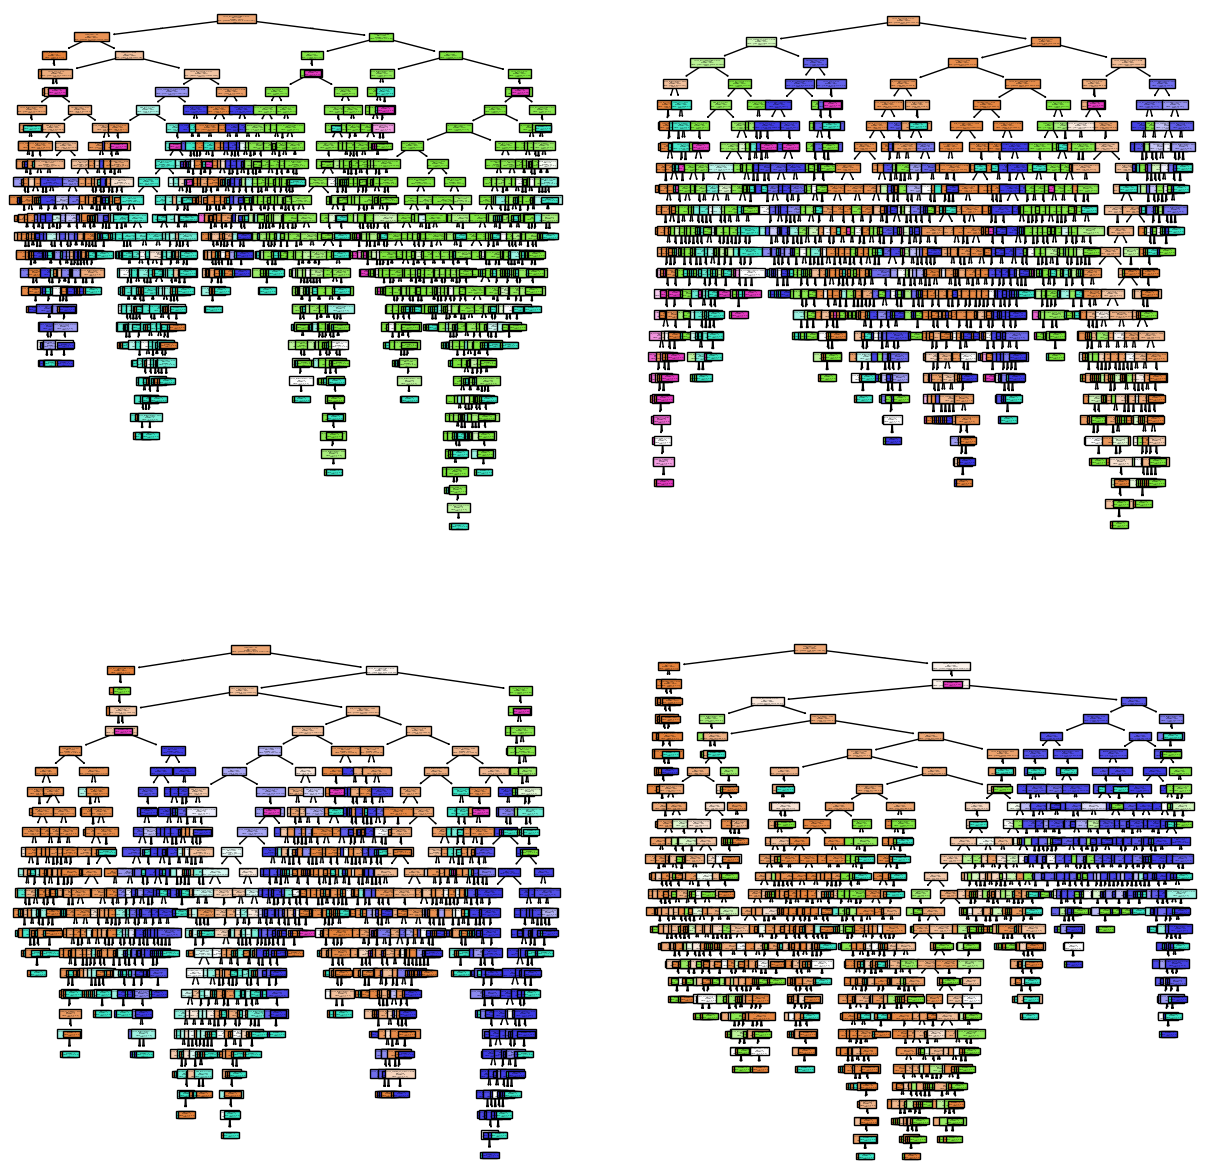

In [79]:
import matplotlib.pyplot as plt
from sklearn import tree

fig, axis = plt.subplots(2, 2, figsize = (15, 15))

# We show the first 4 trees out of the 100 generated (default)
tree.plot_tree(model.estimators_[0], ax = axis[0, 0], feature_names = list(X_train.columns), class_names = ["0", "1", "2","4","5"], filled = True)
tree.plot_tree(model.estimators_[1], ax = axis[0, 1], feature_names = list(X_train.columns), class_names = ["0", "1", "2","4","5"], filled = True)
tree.plot_tree(model.estimators_[2], ax = axis[1, 0], feature_names = list(X_train.columns), class_names = ["0", "1", "2","4","5"], filled = True)
tree.plot_tree(model.estimators_[3], ax = axis[1, 1], feature_names = list(X_train.columns), class_names = ["0", "1", "2","4","5"], filled = True)

In [83]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 1, ..., 0, 0, 0], shape=(41862,))

In [82]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

1.0

# 2. XGB

In [84]:
from xgboost import XGBClassifier

model = XGBClassifier(random_state = 42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [85]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 1, ..., 0, 0, 0], shape=(41862,))

In [86]:
accuracy_score(y_test, y_pred)

1.0